In [2]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import pandas as pd


def find_baseline_moving_avg(file_list, window_size, num_timesteps, num_points):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep=',', skiprows = 0, header= 1)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # interpolate data so that they have the same supports
        x = np.linspace(0, num_timesteps, num=num_points)
        data_array = np.zeros((len(file_list), num_points))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            x_val = df['l'].values.ravel()
            y_val = df['r'].values.ravel()
            f = interp1d(np.cumsum(x_val), y_val, kind='linear',fill_value="extrapolate")
            data_array[i:,] = f(x)
        std = np.std(data_array,axis=0)
        avg = np.mean(data_array,axis=0)
        smoothed_avg = np.zeros(num_points-window_size)
        smoothed_std = np.zeros(num_points-window_size)
        # smooth 
        for i in range(num_points-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std
    
def find_drpo_moving_avg(file_list, window_size, num_timesteps, num_points):  
    if len(file_list) == 1:
        with open(file_list[0], "r") as data:
            data_dict = ast.literal_eval(data.read())
            train_rewards = data_dict['train_rewards']
            data.close()
        train_rewards = np.array(train_rewards)
        data = train_rewards[:,1]
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # interpolate data so that they have the same supports
        x = np.linspace(0, num_timesteps, num=num_points)
        data_array = np.zeros((len(file_list), num_points))
        for i in range(len(file_list)):
            with open(file_list[i], "r") as data:
                data_dict = ast.literal_eval(data.read())
                train_rewards = data_dict['train_rewards']
                data.close()
            train_rewards = np.array(train_rewards)
            x_val = train_rewards[:,0]
            y_val = train_rewards[:,1]
            f = interp1d(x_val, y_val, kind='linear',fill_value="extrapolate")
            data_array[i:,] = f(x)
        std = np.std(data_array,axis=0)
        avg = np.mean(data_array,axis=0)
        smoothed_avg = np.zeros(num_points-window_size)
        smoothed_std = np.zeros(num_points-window_size)
        # smooth 
        for i in range(num_points-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std

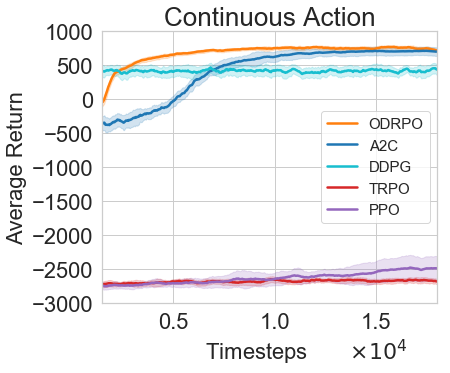

In [29]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

env_name = "ElectricityMarket"
legend = False

ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel("            Timesteps       "+ r"$\times 10^4$",fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

if env_name == "ElectricityMarket": 
    num_timesteps = 2*(10**4)
    num_points = 2000
    window_size = 50
    plt.title('Continuous Action', fontsize = 26)
    plt.ylim(-3000, 1000)
    plt.xlim(0.15, 1.8)
    plt.locator_params(axis="x", nbins=4)
    drpo_file = ['log_files/em_results1_30000_1.txt'
                 , 'log_files/em_results1_20000_1.txt'
                 , 'log_files/em_results1_20000_2.txt'
                ]
    a2c_log_name = ['./tmp/a2c_electricitymarket_monitor1.csv'
                    , './tmp/a2c_electricitymarket_monitor2.csv'
                    ,'./tmp/a2c_electricitymarket_monitor3.csv'
                   ]
    trpo_log_name = ['./tmp/trpo_electricitymarket_monitor1.csv'
                    ,'./tmp/trpo_electricitymarket_monitor2.csv'
                    ,'./tmp/trpo_electricitymarket_monitor3.csv']
    
    ppo_log_name = ['./tmp/ppo_electricitymarket_monitor1.csv'
                    ,'./tmp/ppo_electricitymarket_monitor2.csv'
                    ,'./tmp/ppo_electricitymarket_monitor3.csv'
                    ]
        
    ddpg_log_name = ['./tmp/ddpg_electricitymarket_monitor1.csv'
                     ,'./tmp/ddpg_electricitymarket_monitor2.csv'
                     ,'./tmp/ddpg_electricitymarket_monitor3.csv'
                    ]

with open(drpo_file[0], "r") as data:
    data_dict = ast.literal_eval(data.read())
    train_rewards = data_dict['train_rewards']
    data.close()

moving_average = find_drpo_moving_avg(drpo_file, window_size, num_timesteps, num_points)

if len(drpo_file) > 1:
    x = np.linspace(0, num_timesteps, num=num_points)
    data_length = len(moving_average[0])
    ax.plot(x[len(x)-data_length:len(x)]/10**4, moving_average[0], label='ODRPO', linewidth = 2.5, color = 'tab:orange')
    ax.fill_between(x[len(x)-data_length:len(x)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:orange')
else:
    train_rewards = np.array(train_rewards)
    x_val = train_rewards[:,0]
    data_length = len(moving_average[0])
    ax.plot(x_val[len(x_val)-data_length:len(x_val)]/10**4, moving_average[0], label='ODRPO', linewidth = 2.5, color = 'tab:orange')
    ax.fill_between(x_val[len(x_val)-data_length:len(x_val)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:orange')

# read baseline results
# A2C
moving_average = find_baseline_moving_avg(a2c_log_name, window_size, num_timesteps, num_points)
if len(a2c_log_name) == 1: 
    temp = pd.read_csv(a2c_log_name[0], sep=',', skiprows = 0, header= 1)
    x_val = temp['l']
    data_length = len(moving_average[0])
    ax.plot(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[0], label='A2C', linewidth = 2.5, color = 'tab:blue')
    ax.fill_between(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')
else:
    x = np.linspace(0, num_timesteps, num=num_points)
    data_length = len(moving_average[0])
    ax.plot(x[len(x)-data_length:len(x)]/10**4, moving_average[0], label='A2C', linewidth = 2.5, color = 'tab:blue')
    ax.fill_between(x[len(x)-data_length:len(x)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')

# DDPG
moving_average = find_baseline_moving_avg(ddpg_log_name, window_size, num_timesteps, num_points)
if len(ddpg_log_name) == 1: 
    temp = pd.read_csv(ddpg_log_name[0], sep=',', skiprows = 0, header= 1)
    x_val = temp['l']
    data_length = len(moving_average[0])
    ax.plot(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[0], label='DDPG', linewidth = 2.5, color = 'tab:cyan')
    ax.fill_between(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:cyan')
else:
    x = np.linspace(0, num_timesteps, num=num_points)
    data_length = len(moving_average[0])
    ax.plot(x[len(x)-data_length:len(x)]/10**4, moving_average[0], label='DDPG', linewidth = 2.5, color = 'tab:cyan')
    ax.fill_between(x[len(x)-data_length:len(x)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:cyan')

# TRPO
moving_average = find_baseline_moving_avg(trpo_log_name, window_size, num_timesteps, num_points)
if len(trpo_log_name) == 1: 
    temp = pd.read_csv(trpo_log_name[0], sep=',', skiprows = 0, header= 1)
    x_val = temp['l']
    data_length = len(moving_average[0])
    ax.plot(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[0], label='TRPO', linewidth = 2.5, color = "tab:red")
    ax.fill_between(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = "tab:red")
else:
    x = np.linspace(0, num_timesteps, num=num_points)
    data_length = len(moving_average[0])
    ax.plot(x[len(x)-data_length:len(x)]/10**4, moving_average[0], label='TRPO', linewidth = 2.5, color = "tab:red")
    ax.fill_between(x[len(x)-data_length:len(x)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = "tab:red")
    
# PPO
moving_average = find_baseline_moving_avg(ppo_log_name, window_size, num_timesteps, num_points)
if len(ppo_log_name) == 1: 
    temp = pd.read_csv(ppo_log_name[0], sep=',', skiprows = 0, header= 1)
    x_val = temp['l']
    data_length = len(moving_average[0])
    ax.plot(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[0], label='PPO', linewidth = 2.5, color = "tab:purple")
    ax.fill_between(np.cumsum(x_val)[len(x_val)-data_length:len(x_val)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = "tab:purple")
else:
    x = np.linspace(0, num_timesteps, num=num_points)
    data_length = len(moving_average[0])
    ax.plot(x[len(x)-data_length:len(x)]/10**4, moving_average[0], label='PPO', linewidth = 2.5, color = "tab:purple")
    ax.fill_between(x[len(x)-data_length:len(x)]/10**4, moving_average[1], moving_average[2], alpha=0.2, color = "tab:purple")

ax.legend(loc='center right', fontsize = 15)